<a href="https://colab.research.google.com/github/TAEWOOGWAK/Continual_Learning/blob/main/EWC/EWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Elastic weight consolidation**

##Setting

In [1]:
!pip install sns

  Preparing metadata (setup.py) ... done
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2638 sha256=7c420e77fd62bd9041e8429a45a7732a6851fe30461c52b908eee1967d90649f
  Stored in directory: /root/.cache/pip/wheels/76/1a/47/c3b6a8b9d3ae47b1488f4be13c86586327c07e0ac1bb5b3337
Successfully built sns


In [2]:
import random
import torch
from torchvision import datasets
from copy import deepcopy
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
from tqdm import tqdm
from PIL import Image

In [3]:
epochs = 100
lr = 1e-3
batch_size = 128
sample_size = 256
hidden_size = 256
num_task = 5

In [4]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

In [5]:
class MLP(nn.Module):
    def __init__(self, hidden_size=400):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

## Data load

In [6]:
class PermutedMNIST(datasets.MNIST):

    def __init__(self, root="~/.torch/data/mnist", train=True, permute_idx=None):
        super(PermutedMNIST, self).__init__(root, train, download=True)
        assert len(permute_idx) == 28 * 28
        if self.train:
            self.data = torch.stack([img.float().view(-1)[permute_idx] / 255
                                     for img in self.data])
        else:
            self.data = torch.stack([img.float().view(-1)[permute_idx] / 255
                                     for img in self.data])

    def __getitem__(self, index):
        if self.train:
            img, target = self.data[index], self.targets[index]
        else:
            img, target = self.data[index], self.targets[index]

        return img, target

    def get_sample(self, sample_size):
        sample_idx = random.sample(range(len(self)), sample_size)
        return [img for img in self.data[sample_idx]]




def get_permute_mnist():
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=2)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                     batch_size=batch_size)
        random.shuffle(idx)
    return train_loader, test_loader

In [7]:
train_loader, test_loader = get_permute_mnist()

100%|██████████| 9912422/9912422 [00:00<00:00, 104101155.41it/s]


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/train-images-idx3-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 52782437.40it/s]

Extracting /root/.torch/data/mnist/PermutedMNIST/raw/train-labels-idx1-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26555867.25it/s]


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4461482.15it/s]


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw



### Data visualization

In [8]:
for i in range(5):
  print('Task',i)
  dataset_idx = i
  sample_images = train_loader[dataset_idx].dataset.get_sample(sample_size)
  image = Image.fromarray((sample_images[0].view(28, 28) * 255).byte().numpy(), mode='L')
  image.show()
  print('')

Task 0



Task 1



Task 2



Task 3



Task 4


## Experiment

###Basic model(regularization X)

In [9]:
def normal_train(model: nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader):
    model.train()
    epoch_loss = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target)
        epoch_loss += loss.data
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)


def test(model: nn.Module, data_loader: torch.utils.data.DataLoader):
    model.eval()
    correct = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        output = model(input)
        correct += (F.softmax(output, dim=1).max(dim=1)[1] == target).data.sum()
    return correct / len(data_loader.dataset)


def standard_process(epochs, use_cuda=True, weight=True):
    model = MLP(hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc = {}, {}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []
        for _ in tqdm(range(epochs)):
            loss[task].append(normal_train(model, optimizer, train_loader[task]))
            for sub_task in range(task + 1):
                acc[sub_task].append(test(model, test_loader[sub_task]))

        if task == 0 and weight:
            weight = model.state_dict()

    return loss, acc, weight

In [10]:
loss, acc, weight = standard_process(epochs)

100%|██████████| 100/100 [10:56<00:00,  6.57s/it]


###EWC

In [11]:
class EWC(object):
    def __init__(self, model: nn.Module, dataset: list):

        self.model = model
        self.dataset = dataset

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)

        self.model.eval()
        for input in self.dataset:
            self.model.zero_grad()
            input = variable(input)
            output = self.model(input).view(1, -1)
            label = output.max(1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss



def ewc_train(model: nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader,
              ewc: EWC, importance: float):
    model.train()
    epoch_loss = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target) + importance * ewc.penalty(model)
        epoch_loss += loss.data
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)


def test(model: nn.Module, data_loader: torch.utils.data.DataLoader):
    model.eval()
    correct = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        output = model(input)
        correct += (F.softmax(output, dim=1).max(dim=1)[1] == target).data.sum()
    return correct / len(data_loader.dataset)


def ewc_process(epochs, importance, use_cuda=True, weight=None):
    model = MLP(hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc, ewc = {}, {}, {}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for _ in tqdm(range(epochs)):
                    loss[task].append(normal_train(model, optimizer, train_loader[task]))
                    acc[task].append(test(model, test_loader[task]))
        else:
            old_tasks = []
            for sub_task in range(task):
                old_tasks = old_tasks + train_loader[sub_task].dataset.get_sample(sample_size)
            old_tasks = random.sample(old_tasks, k=sample_size)
            for _ in tqdm(range(epochs)):
                loss[task].append(ewc_train(model, optimizer, train_loader[task], EWC(model, old_tasks), importance))
                for sub_task in range(task + 1):
                    acc[sub_task].append(test(model, test_loader[sub_task]))

    return loss, acc

In [12]:
loss_ewc, acc_ewc = ewc_process(epochs, importance=1000,
#                                 weight=weight
                               )

100%|██████████| 100/100 [14:59<00:00,  8.99s/it]


### Result

In [13]:
def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_task * epochs)), v)
    plt.ylim(0, 1)

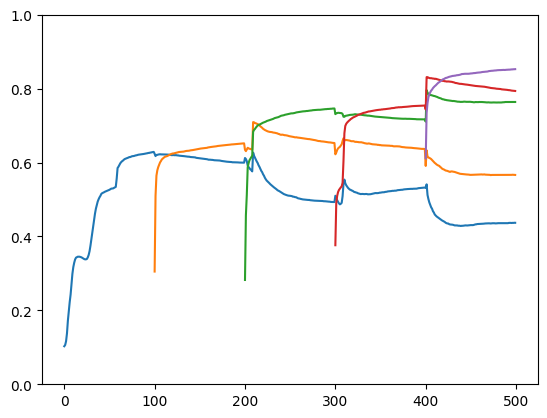

In [16]:
accuracy_plot(acc)

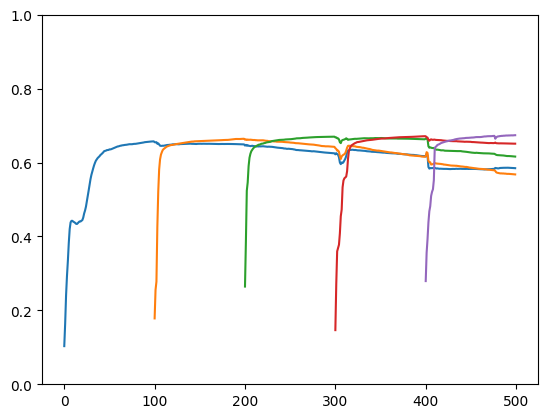

In [17]:
accuracy_plot(acc_ewc)

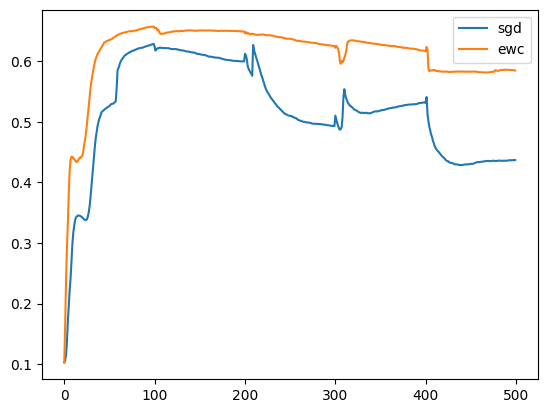

In [18]:
plt.plot(acc[0], label="sgd")
plt.plot(acc_ewc[0], label="ewc")
plt.legend()